In [1]:
from torchvision import transforms,models,datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import torch
import numpy as np
from PIL import Image
import os
from torch import nn
from torchvision.models import vit_b_16
import torch.optim as optim
# from ..opt import read_args
from five_dataset import MyDataset
from models.vit import DualViT
from models.resnet18 import DualResNet
from models.vgg import DualVgg16
import time
from torch.utils.data import random_split
from plot_image import plot_image
from torch.utils.tensorboard import SummaryWriter
from main import load_dataset,criterion1,criterion2
import random
random.seed(42) 



/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

_,_,test_dataset=load_dataset(data_argumentation=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [3]:
from main import select_model
def test(model_path,model_type):
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model=select_model(model_type,True)
    model.load_state_dict(torch.load(model_path))
    ##Testing
    model.eval()
    model.to(device)
    start_time = time.time()
# 
    TP=0
    TN=0
    FP=0
    FN=0
    # 
    C00=0
    C01=0   
    C02=0
    C10=0
    C11=0
    C12=0
    C20=0
    C21=0
    C22=0
    positive_count=0
    negative_count=0
    deep_count=0
    lobar_count=0
    subtentorial_count=0
    # {'Deep': 0, 'Lobar': 1, 'Subtentorial': 2}
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for index, inputs  in enumerate(test_dataloader):
            image, labels1,labels2 = inputs['pixel_values'],inputs['label1'],inputs['label2']
            image = image.to(device)
            labels1= labels1.to(device)
            labels2= labels2.to(device)
            outputs1,outputs2  = model(image)
            _, preds1 = torch.max(outputs1, 1)
            _, preds2 = torch.max(outputs2, 1)
            # batch loss
            loss1 = criterion1(outputs1, labels1)
            loss2 = criterion2(outputs2, labels2)
            # loss = loss1 + loss2
            loss = loss1 + loss2
            # total loss
            running_loss += loss.item() * image.size(0)
            # positive or negetive
            running_corrects += torch.sum(preds1 == labels1.data)
            # confusion matrix for class1
            for i in range(len(preds1)):
                if preds1[i]==labels1[i]:
                    # no: 0, yes: 1
                    if preds1[i]==0:
                        negative_count+=1
                        TP+=1
                    else:
                        positive_count+=1
                        TN+=1
                else:
                    if preds1[i]==0:
                        positive_count+=1
                        FP+=1
                    else:
                        negative_count+=1
                        FN+=1
            # confusion matrix for class2
            for i in range(len(preds2)):
                if preds2[i]==labels2[i]:
                    if preds2[i]==0:
                        C00+=1
                        deep_count+=1
                    elif preds2[i]==1:
                        C11+=1
                        lobar_count+=1
                    elif preds2[i]==2:
                        C22+=1
                        subtentorial_count+=1
                # predict 和 label不一样
                else:
                    # 后一个数字是预测值，前一个数字是真实值
                    if preds2[i]==0:
                        if labels2[i]==1:
                            lobar_count+=1
                            C10+=1
                        elif labels2[i]==2:
                            subtentorial_count+=1
                            C20+=1
                    elif preds2[i]==1:
                        if labels2[i]==0:
                            deep_count+=1
                            C11+=1
                        elif labels2[i]==2:
                            subtentorial_count+=1
                            C21+=1
                    elif preds2[i]==2:
                        if labels2[i]==0:
                            deep_count+=1
                            C02+=1
                        elif labels2[i]==1:
                            lobar_count+=1
                            C12+=1

            running_corrects += torch.sum(preds2 == labels2.data)
            if index == 0:
                print("label1:",labels1.tolist())
                print("preds1:",preds1.tolist())
                print("label2:",labels2.tolist())
                print("preds2:",preds2.tolist())
                plot_image(image, labels1.tolist(), labels2.tolist(), preds1.tolist(), preds2.tolist())
        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / (2* len(test_dataset)) * 100.
        print('[Test] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.
            format(epoch_loss, epoch_acc, time.time() - start_time))
    print('TP:',TP)
    print('TN:',TN)
    print('FP:',FP)
    print('FN:',FN)
    print("deep count",deep_count)
    print("lobar count",lobar_count)
    print("subtentorial count",subtentorial_count)
    print("positive count",positive_count)
    print("negative count",negative_count)
    return TP,TN,FP,FN,C00,C01,C02,C10,C11,C12,C20,C21,C22


## ViT augumented

/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


label1: [0, 1, 1, 0]
preds1: [0, 1, 1, 0]
label2: [3, 1, 0, 3]
preds2: [3, 1, 0, 3]


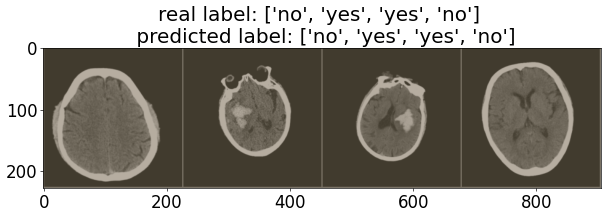

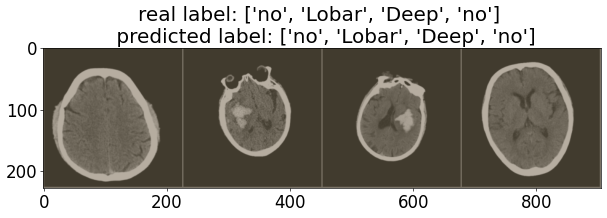

[Test] Loss: 0.0102 Acc: 99.8815% Time: 7.2405s
TP: 459
TN: 807
FP: 0
FN: 0
deep count 599
lobar count 162
subtentorial count 46
positive count 807
negative count 459
TP: 459
TN: 807
FP: 0
FN: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Specificity: 1.0
C00: 597
C01: 0
C02: 2
C10: 1
C11: 161
C12: 0
C20: 0
C21: 0
C22: 46
Accuracy: 0.9962825278810409
Precision: 0.9983277591973244
Recall: 0.996661101836394
F1: 0.9974937343358395
Specificity: 1.0


In [4]:
home_dir='/disk8t/jialiangfan/trained_models/'


# vit model
model_name='dataset-epoche_10-model_type_10-pretrained_True-argumentation_True-batch_size_32-optimizer_type-2.pth'
# model_name='dataset2-epoche_50-model_type_2-pretrained_False-argumentation_True-batch_size_32-optimizer_type-0.pth'
model_type=10
TP,TN,FP,FN, C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))


## Draw the confusion matrix for ViT

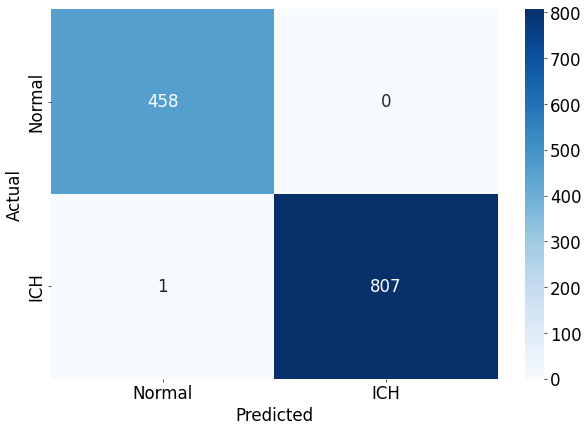

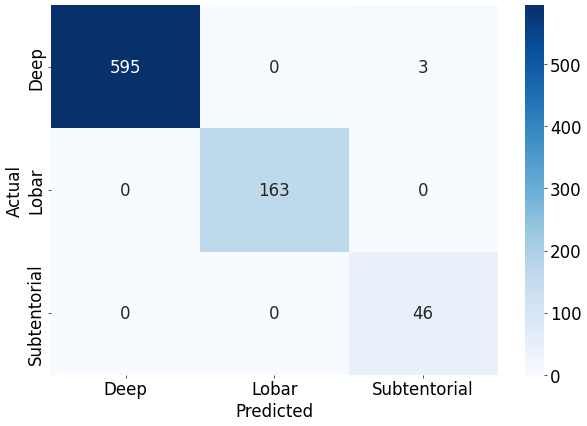

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# 创建混淆矩阵
confusion_matrix1 = np.array([[TP, FP], [FN, TN]])
font_dict={'family':'Times New Roman','size':15}
labels=['Normal','ICH']
# 使用seaborn绘制混淆矩阵
sns.heatmap(confusion_matrix1, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('figs/confusion_matrix_class1.png',dpi=300,bbox_inches='tight')
plt.show()


# 创建混淆矩阵
confusion_matrix2 = np.array([[C00, C01,C02], [C10, C11,C12],[C20, C21,C22]])
font_dict={'family':'Times New Roman','size':15}
labels=['Deep','Lobar','Subtentorial']
# {0:'Deep',1:'Lobar',2:'Subtentorial',3:'no'}
# 使用seaborn绘制混淆矩阵
sns.heatmap(confusion_matrix2, annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('figs/confusion_matrix_class2.png',dpi=300,bbox_inches='tight')
plt.show()

## Vit without augumentation

label1: [0, 1, 1, 0]
preds1: [0, 1, 1, 0]
label2: [3, 1, 0, 3]
preds2: [3, 1, 0, 3]


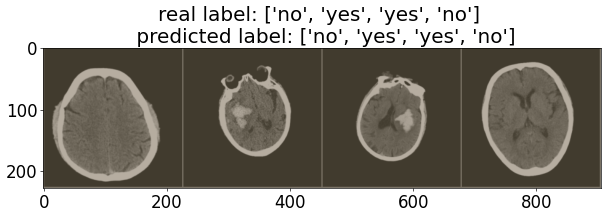

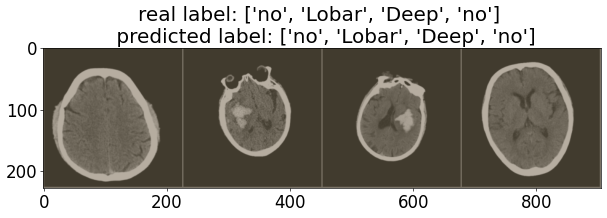

[Test] Loss: 0.0341 Acc: 99.4076% Time: 7.1878s
TP: 459
TN: 803
FP: 4
FN: 0
deep count 596
lobar count 162
subtentorial count 46
positive count 807
negative count 459
TP: 459
TN: 803
FP: 4
FN: 0
Accuracy: 0.9968404423380727
Precision: 0.9913606911447084
Recall: 1.0
F1: 0.9956616052060737
Specificity: 0.9950433705080545
C00: 592
C01: 0
C02: 2
C10: 3
C11: 160
C12: 1
C20: 0
C21: 0
C22: 46
Accuracy: 0.9925373134328358
Precision: 0.9949579831932773
Recall: 0.9966329966329966
F1: 0.9957947855340622
Specificity: 0.9951690821256038


In [17]:

home_dir='/disk8t/jialiangfan/trained_models/'


# vit model
model_name='dataset-epoche_10-model_type_10-pretrained_True-argumentation_False-batch_size_32-optimizer_type-2.pth'
# model_name='dataset2-epoche_50-model_type_2-pretrained_False-argumentation_True-batch_size_32-optimizer_type-0.pth'
model_type=10
TP,TN,FP,FN, C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))


## ResNet augumented

/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


label1: [0, 1, 1, 0]
preds1: [0, 1, 1, 0]
label2: [3, 1, 0, 3]
preds2: [3, 1, 0, 3]


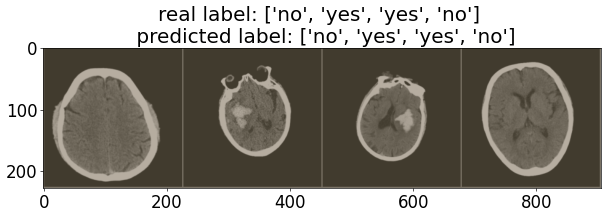

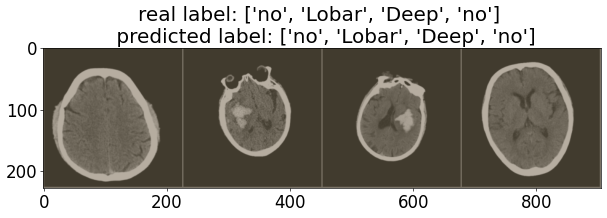

[Test] Loss: 0.0170 Acc: 99.6841% Time: 2.3951s
TP: 459
TN: 806
FP: 1
FN: 0
deep count 598
lobar count 162
subtentorial count 46
positive count 807
negative count 459
TP: 459
TN: 806
FP: 1
FN: 0
Accuracy: 0.9992101105845181
Precision: 0.9978260869565218
Recall: 1.0
F1: 0.998911860718172
Specificity: 0.9987608426270136
C00: 592
C01: 0
C02: 2
C10: 0
C11: 166
C12: 0
C20: 0
C21: 0
C22: 46
Accuracy: 0.9975186104218362
Precision: 1.0
Recall: 0.9966329966329966
F1: 0.9983136593591906
Specificity: 1.0


In [7]:

home_dir='/disk8t/jialiangfan/trained_models/'


# resnet model18
model_name='dataset-epoche_10-model_type_1-pretrained_True-argumentation_True-batch_size_32-optimizer_type-2.pth'
model_type=1
TP,TN,FP,FN, C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type=model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))




## VGG augumented

label1: [0, 1, 1, 0]
preds1: [0, 1, 1, 0]
label2: [3, 1, 0, 3]
preds2: [3, 1, 0, 3]


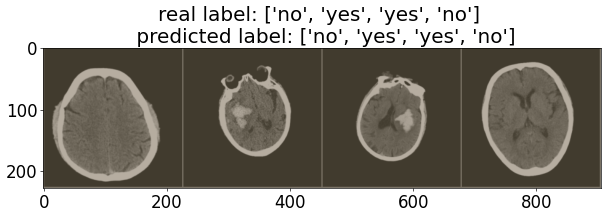

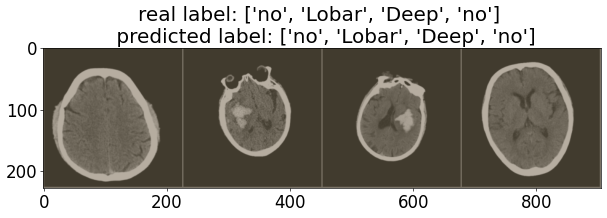

[Test] Loss: 0.0079 Acc: 99.8420% Time: 21.8577s
TP: 459
TN: 807
FP: 0
FN: 0
deep count 599
lobar count 162
subtentorial count 46
positive count 807
negative count 459
TP: 459
TN: 807
FP: 0
FN: 0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Specificity: 1.0
C00: 595
C01: 0
C02: 1
C10: 0
C11: 165
C12: 0
C20: 0
C21: 0
C22: 46
Accuracy: 0.9987608426270136
Precision: 1.0
Recall: 0.9983221476510067
F1: 0.9991603694374476
Specificity: 1.0


In [15]:

home_dir='/disk8t/jialiangfan/trained_models/'


# resnet model
model_name='dataset-epoche_10-model_type_2-pretrained_True-argumentation_True-batch_size_32-optimizer_type-2.pth'
# model_name='dataset2-epoche_50-model_type_2-pretrained_False-argumentation_True-batch_size_32-optimizer_type-0.pth'
#  {0: ViT, 1: ResNet, 2:VGG16, 3:alexnet, 4:squeezenet, 5: ResNet34, 6: ResNet50,7:DenseNet}
model_type=2
TP,TN,FP,FN, C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type=model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))

## AlexNet pretrained


label1: [0, 1, 1, 0]
preds1: [0, 1, 1, 0]
label2: [3, 1, 0, 3]
preds2: [3, 1, 0, 3]


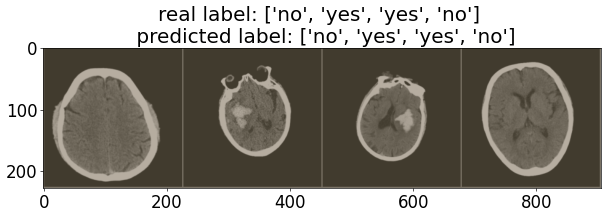

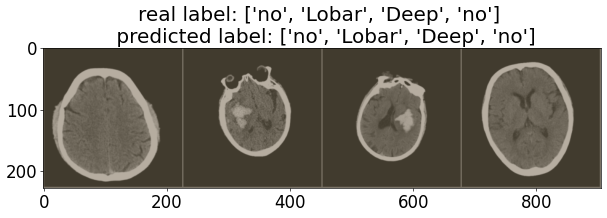

[Test] Loss: 0.0142 Acc: 99.7630% Time: 2.1642s
TP: 459
TN: 806
FP: 1
FN: 0
deep count 597
lobar count 162
subtentorial count 46
positive count 807
negative count 459
TP: 459
TN: 806
FP: 1
FN: 0
Accuracy: 0.9992101105845181
Precision: 0.9978260869565218
Recall: 1.0
F1: 0.998911860718172
Specificity: 0.9987608426270136
C00: 594
C01: 0
C02: 2
C10: 0
C11: 163
C12: 0
C20: 0
C21: 0
C22: 46
Accuracy: 0.9975155279503105
Precision: 1.0
Recall: 0.9966442953020134
F1: 0.9983193277310924
Specificity: 1.0


In [10]:

home_dir='/disk8t/jialiangfan/trained_models/'
model_name='dataset-epoche_10-model_type_3-pretrained_True-argumentation_True-batch_size_32-optimizer_type-2.pth'
#  {0: ViT, 1: ResNet, 2:VGG16, 3:alexnet, 4:squeezenet, 5: ResNet34, 6: ResNet50,7:DenseNet}
model_type=3
TP,TN,FP,FN, C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type=model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))

## SqueezeNet


label1: [0, 1, 1, 0]
preds1: [0, 1, 1, 0]
label2: [3, 1, 0, 3]
preds2: [3, 1, 0, 3]


/home/jialiangfan/miniconda3/envs/medical/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


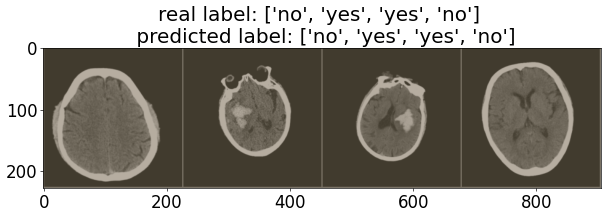

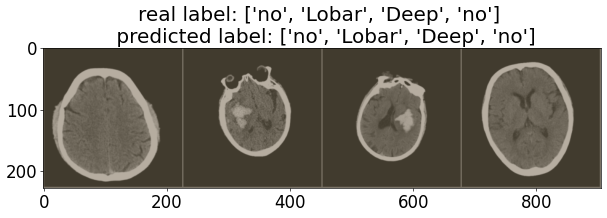

[Test] Loss: 0.1244 Acc: 97.7488% Time: 2.3325s
TP: 457
TN: 806
FP: 1
FN: 2
deep count 596
lobar count 162
subtentorial count 46
positive count 807
negative count 459
TP: 457
TN: 806
FP: 1
FN: 2
Accuracy: 0.9976303317535545
Precision: 0.9978165938864629
Recall: 0.9956427015250545
F1: 0.9967284623773174
Specificity: 0.9987608426270136
C00: 556
C01: 0
C02: 10
C10: 10
C11: 182
C12: 0
C20: 0
C21: 0
C22: 46
Accuracy: 0.9751243781094527
Precision: 0.9823321554770318
Recall: 0.9823321554770318
F1: 0.9823321554770318
Specificity: 1.0


In [11]:

home_dir='/disk8t/jialiangfan/trained_models/'
model_name='dataset-epoche_10-model_type_4-pretrained_True-argumentation_True-batch_size_32-optimizer_type-2.pth'
#  {0: ViT, 1: ResNet, 2:VGG16, 3:alexnet, 4:squeezenet, 5: ResNet34, 6: ResNet50,7:DenseNet}
model_type=4
TP,TN,FP,FN, C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type=model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))

## Densenet 

In [1]:
home_dir='/disk8t/jialiangfan/trained_models/'
model_name='dataset-epoche_10-model_type_7-pretrained_True-argumentation_True-batch_size_32-optimizer_type-2.pth'
#  {0: ViT, 1: ResNet, 2:VGG16, 3:alexnet, 4:squeezenet, 5: ResNet34, 6: ResNet50,7:DenseNet}
model_type=7
TP,TN,FP,FN,C00,C01,C02,C10,C11,C12,C20,C21,C22 =test(home_dir+model_name,model_type=model_type)

# draw the confusion matrix
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

print('Accuracy:',(TP+TN)/(TP+TN+FP+FN))
print('Precision:',TP/(TP+FP))
print('Recall:',TP/(TP+FN))
print('F1:',2*TP/(2*TP+FP+FN))
print('Specificity:',TN/(TN+FP))

print('C00:',C00)
print('C01:',C01)
print('C02:',C02)
print('C10:',C10)
print('C11:',C11)
print('C12:',C12)
print('C20:',C20)
print('C21:',C21)
print('C22:',C22)

print('Accuracy:',(C00+C11+C22)/(C00+C01+C02+C10+C11+C12+C20+C21+C22))
print('Precision:',C00/(C00+C10+C20))
print('Recall:',C00/(C00+C01+C02))
print('F1:',2*C00/(2*C00+C01+C02+C10+C20))
print('Specificity:',(C11+C22)/(C11+C12+C21+C22))

NameError: name 'test' is not defined